<a href="https://www.kaggle.com/code/rayruiyunliu/eeg-eda-gbdt?scriptVersionId=161485791" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os, gc

import pandas as pd, numpy as np
from glob import glob
import matplotlib.pyplot as plt
VER =1

In [2]:
# check the reading of one parquet for understanding

BASE_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'

df = pd.DataFrame({'path': glob(BASE_PATH + '**/*.parquet')})
df['test_type'] = df['path'].str.split('/').str.get(-2).str.split('_').str.get(-1)
df['id'] = df['path'].str.split('/').str.get(-1).str.split('.').str.get(0)


df

,path,test_type,id
0,/kaggle/input/hms-harmful-brain-activity-class...,eegs,2208063991
1,/kaggle/input/hms-harmful-brain-activity-class...,eegs,1712674008
2,/kaggle/input/hms-harmful-brain-activity-class...,eegs,3959808174
3,/kaggle/input/hms-harmful-brain-activity-class...,eegs,2958965493
4,/kaggle/input/hms-harmful-brain-activity-class...,eegs,3973731145
...,...,...,...
28435,/kaggle/input/hms-harmful-brain-activity-class...,spectrograms,1200298045
28436,/kaggle/input/hms-harmful-brain-activity-class...,spectrograms,1455551220
28437,/kaggle/input/hms-harmful-brain-activity-class...,spectrograms,1662527277
28438,/kaggle/input/hms-harmful-brain-activity-class...,eegs,3911565283


In [3]:
df['path'][0]

'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/2208063991.parquet'

In [4]:
df['test_type'].unique()

array(['eegs', 'spectrograms'], dtype=object)

In [5]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape)
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [6]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
{'spectrogram_label_offset_seconds':max})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1, keepdims = True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlap eeg_idd shape:', train.shape)
train.head()

Train non-overlap eeg_idd shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [7]:
READ_SPEC_FILES = False # IF READ_SPEC_FILES is False, the code readds the combined file instead of individual files.
FEATURE_ENGINEER = True
READ_EEG_SPEC_FILES = False

In [8]:
%%time
# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 4.23 s, sys: 8.78 s, total: 13 s
Wall time: 1min 4s


In [9]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

# The code generates features from the spectrogram data for use in a model 
# The features are derived by calculating the mean and minimum values over time for each of the 400 spectrogram frequencies.
# Two types of windows are used for these calculations:
# A 10-minute window (_mean_10m, _min_10m).
# A 20-second window (_mean_20s, _min_20s).
# This process results in 1600 features (400 features × 4 calculations) for each EEG ID.

SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]

print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')

# A data matrix data is initialized to store the new features for each eeg_id in the train DataFrame.
# For each row in train, the code calculates the mean and minimum values within the specified 10-minute and 20-second windows.
# These calculated values are then stored in the data matrix.
# Finally, the matrix is added to the train DataFrame as new columns.

if FEATURE_ENGINEER:
    data = np.zeros((len(train),len(FEATURES)))
    for k in range(len(train)):
        if k%100==0: print(k,', ',end='')
        row = train.iloc[k]
        r = int( (row['min'] + row['max'])//4 ) 
        
        # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,:400] = x
        x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,400:800] = x
        
        # 20 SECOND WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,800:1200] = x
        x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,1200:1600] = x
        
    train[FEATURES] = data
else:
    train = pd.read_parquet('/kaggle/input/brain-spectrograms/train.pqt')
print()
print('New train shape:',train.shape)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.11 µs
We are creating 1600 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 

In [10]:
from scipy import signal
from sklearn.decomposition import PCA

In [11]:
def extract_frequency_band_features(segment):
    # Define EEG frequency bands
    eeg_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 45)}
    
    band_features = []
    for band in eeg_bands:
        low, high = eeg_bands[band]
        # Filter signal for the specific band
        band_pass_filter = signal.butter(3, [low, high], btype='bandpass', fs=200, output='sos')
        filtered = signal.sosfilt(band_pass_filter, segment)
        # Extract features like mean, standard deviation, etc.
        band_features.extend([np.nanmean(filtered), np.nanstd(filtered), np.nanmax(filtered), np.nanmin(filtered)])
    
    return band_features

In [12]:
train.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,RP_18.16_min_20s,RP_18.36_min_20s,RP_18.55_min_20s,RP_18.75_min_20s,RP_18.95_min_20s,RP_19.14_min_20s,RP_19.34_min_20s,RP_19.53_min_20s,RP_19.73_min_20s,RP_19.92_min_20s
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,0.20,0.19,0.17,0.16,0.25,0.21,0.17,0.19,0.15,0.13
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.02,0.02,0.02
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,0.05,0.04,0.07,0.05,0.04,0.06,0.03,0.06,0.05,0.05
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,0.06,0.05,0.05,0.06,0.06,0.06,0.07,0.05,0.05,0.03
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,0.15,0.15,0.13,0.13,0.08,0.06,0.06,0.12,0.09,0.04


In [13]:
import xgboost as xgb
import gc
from sklearn.model_selection import KFold, GroupKFold

print('XGBoost version', xgb.__version__)

XGBoost version 2.0.3


In [14]:
all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train , train .target, train .patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    model = xgb.XGBClassifier(
        objective='multi:softprob', 
        num_class=len(TARS),
        learning_rate = 0.1, 
                      
#         tree_method='gpu_hist',  #skip GPU acceleration
    )
    
    # Prepare training and validation data
    X_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, 'target'].map(TARS)
    X_valid = train.loc[valid_index, FEATURES]
    y_valid = train.loc[valid_index, 'target'].map(TARS)
    
    model.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], 
              verbose=True, 
              early_stopping_rounds=10)
    model.save_model(f'XGB_v{VER}_f{i}.model')
    
    oof = model.predict_proba(X_valid)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, TARGETS].values)
    
    del X_train, y_train, X_valid, y_valid, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
[0]	validation_0-mlogloss:1.71525
[1]	validation_0-mlogloss:1.65074
[2]	validation_0-mlogloss:1.59639
[3]	validation_0-mlogloss:1.54921
[4]	validation_0-mlogloss:1.51127
[5]	validation_0-mlogloss:1.47471
[6]	validation_0-mlogloss:1.44130
[7]	validation_0-mlogloss:1.41417
[8]	validation_0-mlogloss:1.38801
[9]	validation_0-mlogloss:1.36416
[10]	validation_0-mlogloss:1.34616
[11]	validation_0-mlogloss:1.32763
[12]	validation_0-mlogloss:1.30994
[13]	validation_0-mlogloss:1.29378
[14]	validation_0-mlogloss:1.28079
[15]	validation_0-mlogloss:1.26874
[16]	validation_0-mlogloss:1.25603
[17]	validation_0-mlogloss:1.24528
[18]	validation_0-mlogloss:1.23556
[19]	validation_0-mlogloss:1.22740
[20]	validation_0-mlogloss:1.22049
[21]	validation_0-mlogloss:1.21151
[22]	validation_0-mlogloss:1.20529
[23]	validation_0-mlogloss:1.19835
[24]	validation_0-mlogloss:1.19216
[25]	validation_0-mlogloss:1.18574

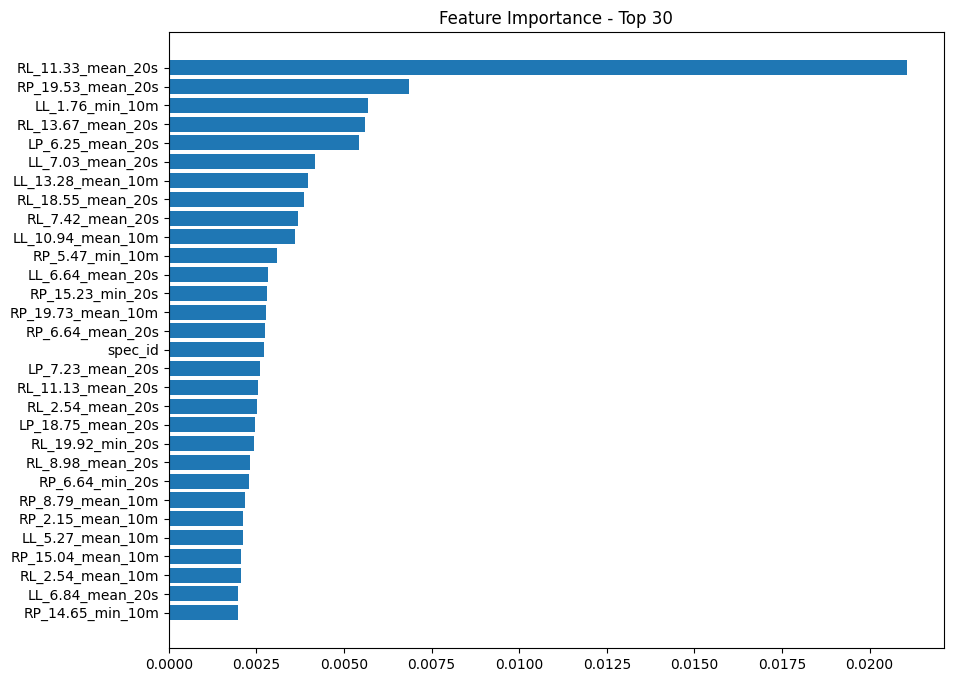

In [15]:
TOP = 30

# Assuming 'model' is your trained model
feature_importance = model.feature_importances_

# Get the feature names from 'train'
feature_names = train.columns

# Sort the feature importances and get the indices of the sorted array
sorted_idx = np.argsort(feature_importance)

# Plot only the top 'TOP' features
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

In [16]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)


CV Score KL-Div for CatBoost = 0.8391212230558691


In [17]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [18]:
# FEATURE ENGINEER TEST
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
data = np.zeros((len(test),len(FEATURES)))
    
for k in range(len(test)):
    row = test.iloc[k]
    s = int( row.spectrogram_id )
    spec = pd.read_parquet(f'{PATH2}{s}.parquet')
    
    # 10 MINUTE WINDOW FEATURES
    x = np.nanmean( spec.iloc[:,1:].values, axis=0)
    data[k,:400] = x
    x = np.nanmin( spec.iloc[:,1:].values, axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES
    x = np.nanmean( spec.iloc[145:155,1:].values, axis=0)
    data[k,800:1200] = x
    x = np.nanmin( spec.iloc[145:155,1:].values, axis=0)
    data[k,1200:1600] = x

    
    
    
test[FEATURES] = data
print('New test shape',test.shape)

New test shape (1, 1603)


In [19]:
# INFER XGBOOST ON TEST
preds = []

for i in range(5):
    print(i, ', ', end='')
    
    # Load the XGBoost model
    model = xgb.XGBClassifier()
    model.load_model(f'XGB_v{VER}_f{i}.model')
    
    # Make predictions
    pred = model.predict_proba(test[FEATURES])
    preds.append(pred)

# Average the predictions from each fold
pred = np.mean(preds, axis=0)
print()
print('Test preds shape', pred.shape)

0 , 1 , 2 , 3 , 4 , 
Test preds shape (1, 6)


In [20]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
sub.head()

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.100642,0.068947,0.005433,0.104553,0.034289,0.686136


In [21]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32